### We fix change point range equels 0.8 and see the prediction for  1 spare part

In [1]:
## import and load in
import pandas as pd
import numpy as np

import os

df=pd.read_csv('LRU_order_among_the_years.csv', header=1)
df.head()

,LRU,Abbeville,Aberaeron,Aberdeen,Abilene,Abingdon,Absecon,Acworth,Ada,Addison,...,Hayden,Hays,Haysville,Hayward,Hazard,Hazel Crest,Hazel Park,Hazelwood,Hazleton,Healdsburg
0,DateOrdre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-07-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-08-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2009-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. Preprocessing

In [2]:
# delete the first line 
df=df.drop(df.index[0])
df.reset_index(drop=True, inplace=True)
df.head()

,LRU,Abbeville,Aberaeron,Aberdeen,Abilene,Abingdon,Absecon,Acworth,Ada,Addison,...,Hayden,Hays,Haysville,Hayward,Hazard,Hazel Crest,Hazel Park,Hazelwood,Hazleton,Healdsburg
0,2009-07-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009-08-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2009-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#choose the spare part we want, delete other colomns  and change the formula to do ''Prophet'' training
PARA = 'Cahokia'
df=df[['LRU',PARA]]
df['ds'] = df['LRU']
df['y'] = df[PARA]
df = df.drop(['LRU',PARA],axis=1)
df.head()

,ds,y
0,2009-07-21,0.0
1,2009-08-25,0.0
2,2009-09-03,0.0
3,2009-09-04,0.0
4,2009-10-02,0.0


In [4]:
## do the sum of commandes and get the new list  
Sum_Aberaeron = df
Sum_Aberaeron.reset_index(drop=True, inplace=True)
Sum_Aberaeron.head()

,ds,y
0,2009-07-21,0.0
1,2009-08-25,0.0
2,2009-09-03,0.0
3,2009-09-04,0.0
4,2009-10-02,0.0


In [5]:
Sum_Aberaeron['ds'] = pd.to_datetime(Sum_Aberaeron['ds'])
Sum_Aberaeron.sort_values('ds',inplace=True)
Sum_Aberaeron.head()

,ds,y
0,2009-07-21,0.0
1,2009-08-25,0.0
2,2009-09-03,0.0
3,2009-09-04,0.0
4,2009-10-02,0.0


In [6]:
Sum_Aberaeron['cumsum']=Sum_Aberaeron['y'].cumsum()
Sum_Aberaeron['y']=Sum_Aberaeron['cumsum']
Sum_Aberaeron  =Sum_Aberaeron.drop(['cumsum'],axis=1)
Sum_Aberaeron.tail()

,ds,y
1529,2018-09-20,288.0
1530,2018-09-21,288.0
1531,2018-09-24,288.0
1532,2018-09-25,288.0
1533,2018-09-26,288.0


In [7]:
# split the training set and test set: training :'from 2009 to '20171231' , testing :'from 20180101 to '20180926' 
train=Sum_Aberaeron[Sum_Aberaeron['ds']<'20180101']
test=Sum_Aberaeron[Sum_Aberaeron['ds']>'20171231']
# a=Sum_Aberaeron.loc[1]

# the pente from 20170101 to 20171231 : ecart of the command / 365
start=Sum_Aberaeron[Sum_Aberaeron['ds']=='20170101']
end=Sum_Aberaeron[Sum_Aberaeron['ds']=='20171231']
pente=(end['y'].values[0]-start['y'].values[0])/365
pente

0.24383561643835616

### 2. Training

In [8]:
#prophet traing
from fbprophet import Prophet
m = Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000)
m.fit(train)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods=365)

In [10]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,191.300855,187.579848,194.815654
1,2018-01-02,191.453276,187.667550,195.651208
2,2018-01-03,191.640606,187.621727,195.491343
3,2018-01-04,191.731138,188.115955,195.510974
4,2018-01-05,191.945093,187.911751,195.760409
5,2018-01-08,191.905889,187.835284,195.824856
6,2018-01-09,192.071751,188.374096,196.176884
7,2018-01-10,192.279394,188.485498,196.492171
8,2018-01-11,192.396691,188.631709,196.202461
9,2018-01-12,192.643397,188.543412,196.569991


### 3. Result comparasion

In [11]:
# calculate the grow rate in year 2018  for both the true data and prediction
firstday = forecast[forecast['ds']=='20180101']
lastday = forecast[forecast['ds']=='20180926']
predict_grow_rate= (lastday['yhat'].values[0] - firstday['yhat'].values[0])/firstday['yhat'].values[0]
print(PARA+' predict_grow_rate : ' +str(predict_grow_rate))

# print("Generalization error: %g"%(1.-rf.score(Xtest,ytest)))

firstday_test = test[test['ds']=='20180101']
lastday_test = test[test['ds']=='20180926']
true_grow_rate = (lastday_test['y'].values[0] - firstday_test['y'].values[0])/firstday_test['y'].values[0]
print(PARA+' true_grow_rate: ' + str(true_grow_rate))

#calculate the prediction error

print(PARA+' predict_error: ' + str( np.abs(predict_grow_rate-true_grow_rate)/true_grow_rate ))


Cahokia predict_grow_rate : 0.3184945131780157
Cahokia true_grow_rate: 0.43283582089552236
Cahokia predict_error: 0.2641678488645844


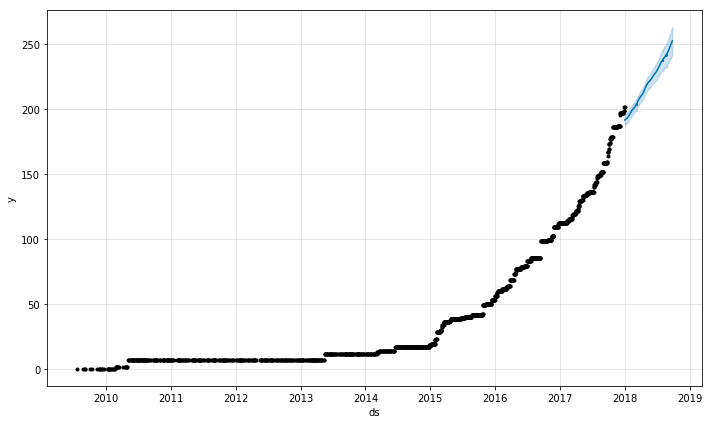

In [12]:
fig1 = m.plot(forecast)

In [13]:
?Prophet

##### #可以判断最后一段的斜率 然后调整changepoint rate 如果大 则把changepoint rate跳的接近于一
1.  首先要能选择每一个零件
2. 然后要判断最近一年的斜率
3. 设定一个阀值
4. 根据大于小于阀值来判断changepoint rate 的大小
5. 训练对比数据